<a href="https://colab.research.google.com/github/poojamahajan0712/code_clarity/blob/main/Understanding_transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understanding transformer helper functions


In [2]:
import numpy as np
import tensorflow as tf

1. Positional Embedding <br>
*  i // 2 is used to group each consecutive pair of dimensions (one sine, one cosine) to use the same base frequency.
* This ensures that adjacent dimensions (e.g., i = 0, 1, or i = 2, 3) share the same frequency, but the even index uses sine, and the odd index uses cosine, encoding positional information in both dimensions.
	https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/


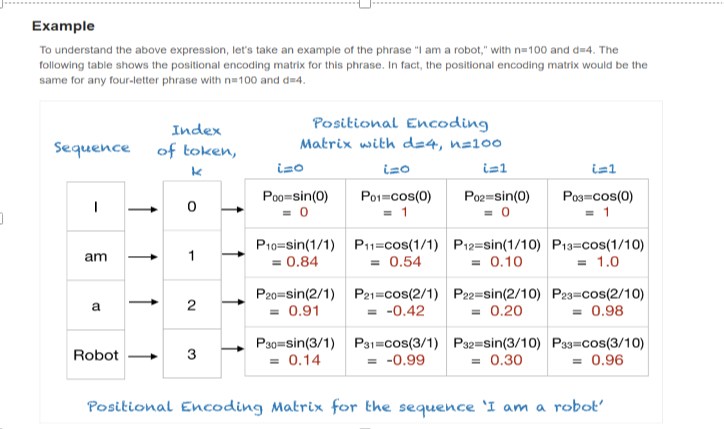

In [ ]:

position = 10
pos1 = np.arange(position)[:, np.newaxis]
pos1.shape

(10, 1)

In [ ]:
# i // 2 is used to group each consecutive pair of dimensions (one sine, one cosine) to use the same base frequency.
# This ensures that adjacent dimensions (e.g., i = 0, 1, or i = 2, 3) share the same frequency, but the even index uses sine, and the odd index uses cosine, encoding positional information in both dimensions.


def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    print(angle_rads)
    print(angle_rads.shape)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
position =4
d_model = 5 # embedding length
out = positional_encoding(position, d_model)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 2.51188643e-02 2.51188643e-02
  6.30957344e-04]
 [2.00000000e+00 2.00000000e+00 5.02377286e-02 5.02377286e-02
  1.26191469e-03]
 [3.00000000e+00 3.00000000e+00 7.53565929e-02 7.53565929e-02
  1.89287203e-03]]
(4, 5)


In [ ]:
out

<tf.Tensor: shape=(1, 4, 5), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
          0.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  2.5116222e-02,  9.9968451e-01,
          6.3095731e-04],
        [ 9.0929741e-01, -4.1614684e-01,  5.0216600e-02,  9.9873835e-01,
          1.2619144e-03],
        [ 1.4112000e-01, -9.8999250e-01,  7.5285293e-02,  9.9716204e-01,
          1.8928709e-03]]], dtype=float32)>

In [ ]:
out.shape

TensorShape([1, 4, 5])

2. Look ahead mask
*  This function creates a look-ahead mask to prevent the decoder from "cheating" by seeing future tokens when predicting the next word.

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


In [ ]:
size=5
create_look_ahead_mask(size)


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

3. scaled_dot_product_attention

In [4]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [5]:
# Embedding matrix for sentence ("I", "love", "NLP")
q = tf.constant([[1, 0, 1, 0],  # I
                 [0, 2, 0, 2],  # love
                 [1, 1, 1, 1]],  # NLP
                dtype=tf.float32)  # Q = K = V for self-attention

k = q  # For self-attention, K = Q
v = q  # For self-attention, V = Q

# No mask in this simple example
mask = None


In [6]:
matmul_qk = tf.matmul(q, k, transpose_b=True)# (3,4)*(4,3) - (3,3)
matmul_qk

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[2., 0., 2.],
       [0., 8., 4.],
       [2., 4., 4.]], dtype=float32)>

In [7]:
tf.shape(k)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>

In [8]:
dk = tf.cast(tf.shape(k)[-1], tf.float32)  # dk = 4.0 (since k has 4 features)
scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
scaled_attention_logits

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 1.],
       [0., 4., 2.],
       [1., 2., 2.]], dtype=float32)>

In [9]:
#  softmax to the scaled logits to get the attention weights, ensuring that they sum up to 1 along each row.
attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
attention_weights

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.42231882, 0.15536241, 0.42231882],
       [0.01587624, 0.8668133 , 0.11731042],
       [0.15536241, 0.42231882, 0.42231882]], dtype=float32)>

In [10]:
output = tf.matmul(attention_weights, v) # (3,3)*(3,4) = (3,4)
output

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.84463763, 0.7330437 , 0.84463763, 0.7330437 ],
       [0.13318665, 1.850937  , 0.13318665, 1.850937  ],
       [0.57768124, 1.2669564 , 0.57768124, 1.2669564 ]], dtype=float32)>

MultiHeadAttention class

In [27]:
# d_model: The total dimensionality of the model's output space.~ embedding size
# num_heads: The number of parallel attention heads.
# depth: This represents the size of each attention head. It's calculated by dividing d_model by num_heads. Each head works on a reduced subspace of the total model dimension.
# wq, wk, wv: These are Dense layers that project the input into query (q), key (k), and value (v) vectors, which are essential components of the attention mechanism.
# dense: A final Dense layer applied after concatenating the heads to project the output back to d_model.


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # d_model: The total dimensionality of the model's output space.~ embedding size
        # num_heads: The number of parallel attention heads.

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        # wq, wk, wv: These are Dense layers that project the input into query (q), key (k), and value (v) vectors
        # dense: A final Dense layer applied after concatenating the heads to project the output back to d_model.

    #input tensor x has shape (batch_size, seq_len, d_model). This function reshapes it to split the d_model dimension into multiple heads.
    #reshaped tensor has shape (batch_size, seq_len, num_heads, depth), where depth = d_model // num_heads.
    # Then, the tensor is transposed to bring num_heads into the second dimension with shape (batch_size, num_heads, seq_len, depth), which makes it easier to compute attention for each head independently.

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        # print("before",q.shape)
        q = self.split_heads(q, batch_size) #Each of the q, k, and v tensors is split into multiple heads using the split_heads function, producing tensors with shape (batch_size, num_heads, seq_len, depth).
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # print("after",q.shape)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        # print("original shape")
        # print(scaled_attention.shape)   # The scaled_dot_product_attention function is called to calculate the attention scores for each head. This function computes scaled dot-product attention for all the heads in parallel, returning the attended values (scaled_attention) and the attention weights (attention_weights).

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # print("transposed shape")
        # print(scaled_attention.shape)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # The scaled_attention is transposed back to the original order of dimensions and concatenated across all heads to have the shape (batch_size, seq_len, d_model).
        # print("concat_attention shape")
        # print(concat_attention.shape)
        output = self.dense(concat_attention)
        # print("output shape")
        # print(output.shape)

        return output, attention_weights

In [28]:
# Example input
d_model = 512  # Dimensionality of the model
num_heads = 8  # Number of attention heads
seq_len = 10   # Length of the input sequence
batch_size = 64

# Create random input tensors for query, key, and value
q = tf.random.uniform((batch_size, seq_len, d_model))  # (batch_size, seq_len, d_model)
k = tf.random.uniform((batch_size, seq_len, d_model))  # (batch_size, seq_len, d_model)
v = tf.random.uniform((batch_size, seq_len, d_model))  # (batch_size, seq_len, d_model)

# Instantiate the MultiHeadAttention layer
mha = MultiHeadAttention(d_model, num_heads)

# Call the layer
output, attention_weights = mha(v, k, q,None)

# Output shapes
print(f"Output shape: {output.shape}")  # Should be (batch_size, seq_len, d_model)
print(f"Attention weights shape: {attention_weights.shape}")  # Should be (batch_size, num_heads, seq_len, seq_len)


before (64, 10, 512)
after (64, 8, 10, 64)
before (64, 10, 512)
after (64, 8, 10, 64)
Output shape: (64, 10, 512)
Attention weights shape: (64, 8, 10, 10)
